<a href="https://colab.research.google.com/github/Faizan-Siddique/Rice_Leaf_Disease_Classification/blob/main/Rice_Leaf_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rice Leaf Disease Classification

### Importing Libararies 

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Specify training data directory
Images = '/content/drive/MyDrive/PRCP-1001-RiceLeaf/Data'

In [4]:
# List the folders in the directory
os.listdir(Images)

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [5]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255,validation_split= 0.2)

In [6]:
# Generate batches of 40 images
# Total number of images is  = 119 images
# Training is 96 (80%) and validation is 24 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, directory= Images, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="training")


Found 74 images belonging to 3 classes.


In [7]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= Images, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")


Found 18 images belonging to 3 classes.


In [8]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)


In [9]:
train_images.shape

(40, 256, 256, 3)

In [10]:
train_labels.shape

(40, 3)

In [11]:
train_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

## Visualizing Dataset

In [12]:
# labels Translator 
label_names = {0 : 'Leaf smut', 1 : 'Brown spot' , 2: 'Bacterial leaf blight'}

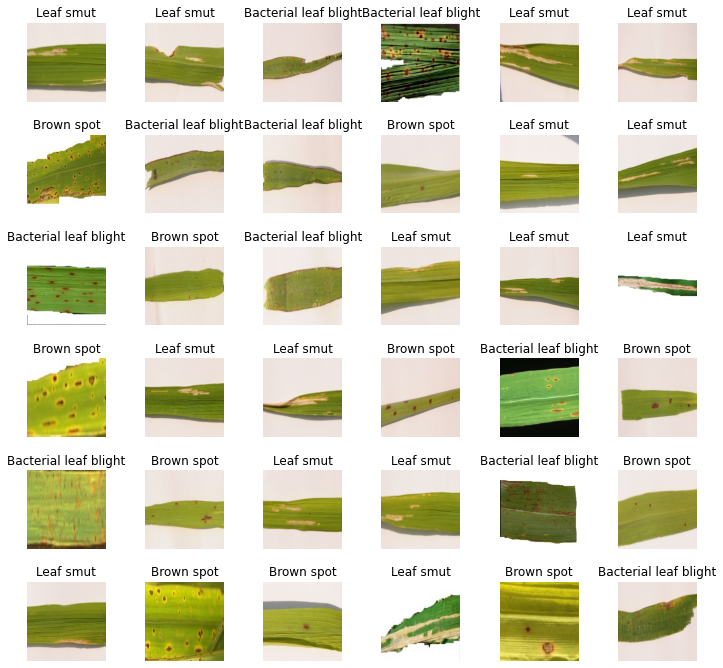

In [13]:
# Create a grid of 36 images along with their corresponding labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

## Using ResNet - 50 To train CNN model

In [14]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

In [15]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

## Building Model

In [17]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(3, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 1e-4, decay = 1e-6), metrics= ["accuracy"])

In [19]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [20]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= Images, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= Images, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 74 images belonging to 3 classes.
Found 18 images belonging to 3 classes.


In [21]:
history = model.fit_generator(train_generator, epochs = 10, validation_data= val_generator,callbacks=[checkpointer, earlystopping])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
19/19 [==============================] - 17s 270ms/step - loss: 1.5598 - accuracy: 0.4189 - val_loss: 1.0991 - val_accuracy: 0.3333

Epoch 00001: val_loss improved from inf to 1.09914, saving model to weights.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
19/19 [==============================] - 3s 165ms/step - loss: 0.6090 - accuracy: 0.7568 - val_loss: 1.3974 - val_accuracy: 0.3333

Epoch 00002: val_loss did not improve from 1.09914
Epoch 3/10
19/19 [==============================] - 3s 164ms/step - loss: 0.2795 - accuracy: 0.9189 - val_loss: 1.1299 - val_accuracy: 0.3333

Epoch 00003: val_loss did not improve from 1.09914
Epoch 4/10
19/19 [==============================] - 3s 165ms/step - loss: 0.2948 - accuracy: 0.8919 - val_loss: 1.1266 - val_accuracy: 0.3333

Epoch 00004: val_loss did not improve from 1.09914
Epoch 5/10
19/19 [==============================] - 3s 165ms/step - loss: 0.0348 - accuracy: 1.0000 - val_loss: 1.1205 - val_accuracy: 0.3333

Epoch 00005: val_loss did not improve from 1.09914
Epoch 6/10
19/19 [==============================] - 3s 164ms/step - loss: 0.1314 - accuracy: 0.9459 - val_loss: 1.1805 - val_accuracy: 0.3333

Epoch 00006: val_loss did not improve from 1.09914
Epoch 7/10
19/19 [============

## Evaluating Model Performance

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

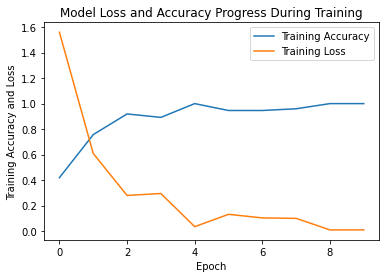

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

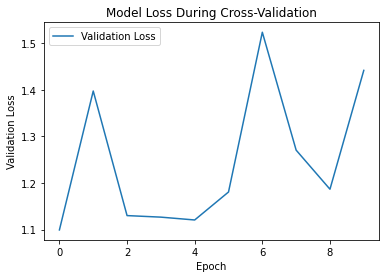

In [24]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

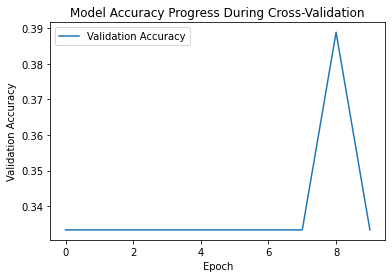

In [25]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [26]:
test_directory = '/content/drive/MyDrive/PRCP-1001-RiceLeaf/Test_Data'


In [27]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 27 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: 1.5066 - accuracy: 0.2963
Accuracy Test : 0.29629629850387573
